## 2.1 Cleaning and Preparation of Dataset
### 2.1.1 Data Load
The first step in the data analysis process is to load the data into a pandas DataFrame. 

As analyzed in the data exploration section, the data is stored in a CSV file that doesn't include a header row. The data is loaded into a pandas DataFrame and headers are added manually.

**Note:** I am importing the `utils.py` file to implement graphing functions.

In [1]:
import pandas as pd
import utils

df = pd.read_csv("datasets/census_income.csv")

# Column names added to the dataset
attribute_names = [ # Improving clarity of names
    "age",
    "workclass",
    "final_weights",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income"
]

df.columns = attribute_names

# Preprocessing steps
text_cols = df.select_dtypes(exclude=['number']).columns.tolist()
for col in text_cols:
    df[col] = df[col].str.strip()

df.head()

,age,workclass,final_weights,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


### 2.1.2 Data Cleaning: Handling Missing Values

My exploratory analysis revealed missing values in the dataset. Althought they were not empty, missingness was represented as question marks on some of the categorical columns. As stated in the ***Data Quality*** section of the data exploration notebook, I will replace these question marks as a missing category (Replacing them with any other value such as the mode or median would be counterproductive as it would bias the analysis towards the most common values).

C:\Users\danie\AppData\Local\Temp\ipykernel_42576\1384496257.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


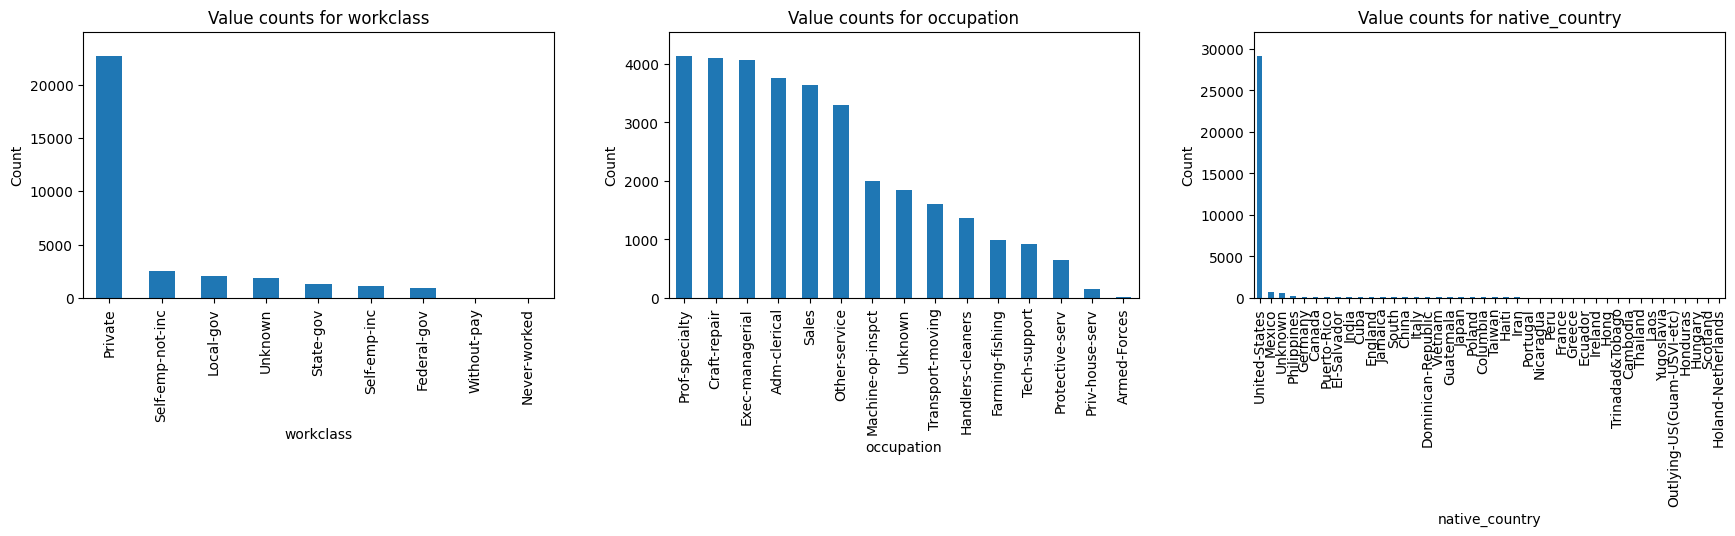

In [2]:
df['workclass'] = df['workclass'].apply(lambda x: 'Unknown' if x.strip() == '?' else x)
df['occupation'] = df['occupation'].apply(lambda x: 'Unknown' if x.strip() == '?' else x)
df['native_country'] = df['native_country'].apply(lambda x: 'Unknown' if x.strip() == '?' else x)

fig = utils.plot_categorical_value_counts(df, ['workclass', 'occupation', 'native_country'])
fig.show()

Missing values handled.

### 2.1.3 Data Cleaning: Handling Duplicates

Several duplicates were found in the dataset. I arrived to the conclusion that these were errors in the data collection process, and would need to be dropped. This was done using the `drop_duplicates()` method, using the `keep="first"` parameter to keep the first occurrence of each duplicate as this is relevant to the analysis.

In [3]:
df = df.drop_duplicates(keep='first')
print("Number of duplicates:", df.duplicated().sum())

Number of duplicates: 0


### 2.1.4 Format Standardization

Standarization is key to ensuring data quality and efficient storing. Steps needed to take are:

1. The relationship between both `education_num` and `education` columns can be explained by a dictionary. This is a good way to save storage and still represent the same data. I am going to create a dictionary to map the values of `education_num` to the values of `education` and drop the `education_num` column.
2. Standarize the `workclass` column by arranging classes with similar meaning in the same category, using a predefined dictionary.
3. Binning the `age` column into 5 intervals in order to reduce the number of unique values and make the data more manageable. Possible drop the `age` column.
4. Standarize the `relationship` column by arranging classes with similar meaning in the same category, using a predefined dictionary. I noticed that I have both husband and wife, but this could be defined as married. Additionally, I noticed the dataset is biased towards male workers, and so this column would communicate overlapping information if unchanged. This column was also modified to show people who are not in a family and that are other relatives to be unmarried.

In [4]:
# 1. Implementing the Dictionary

education_num_dict = df[['education_num','education']].drop_duplicates().set_index('education')['education_num'].to_dict()
df.drop(columns=['education_num'], inplace=True)
print(f'Resultant Dictionary:\n {education_num_dict}')


# 2. Implementing the workclass standardization
workclass_map = {
    'Self-emp-not-inc': 'Self-employed',
    'Self-emp-inc': 'Self-employed',
    'Federal-gov': 'Government',
    'State-gov': 'Government',
    'Local-gov': 'Government',
    'Private': 'Private',
    'Without-pay': 'Other',
    'Never-worked': 'Other'
}
df['workclass'] = df['workclass'].apply(lambda x: workclass_map[x.strip()] 
                                        if x.strip() in workclass_map else x.strip())
print("Showing workclass value counts:\n", df['workclass'].value_counts())

# 3. Binning the age column
age_bins = [0, 25, 35, 50, 65, 100]
age_labels = ['18-25', '26-35', '36-50', '51-65', '65+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

#4. Implementing the marital status standardization
df['relationship'] = df['relationship'].apply(lambda x: 'Married' 
                                                        if x.strip().lower() in ['husband', 'wife'] 
                                                        else x.strip())

df.replace(["Not-in-family","Other-relative"], "Unmarried", inplace=True)                                            
print("Showing relationship value counts:\n", df['relationship'].value_counts())


Resultant Dictionary:
 {'Bachelors': 13, 'HS-grad': 9, '11th': 7, 'Masters': 14, '9th': 5, 'Some-college': 10, 'Assoc-acdm': 12, 'Assoc-voc': 11, '7th-8th': 4, 'Doctorate': 16, 'Prof-school': 15, '5th-6th': 3, '10th': 6, '1st-4th': 2, 'Preschool': 1, '12th': 8}
Showing workclass value counts:
 workclass
Private          22673
Government        4350
Self-employed     3656
Unknown           1836
Other               21
Name: count, dtype: int64
Showing relationship value counts:
 relationship
Married      14755
Unmarried    12717
Own-child     5064
Name: count, dtype: int64


### 2.1.5. Convert Data Types
The only columns that I considered converting were the capital related columns from `int64` to `float64`. This is because althought the values are approximanted to integer values, there may be a need for a more detailed visual on the money values.
- The `income` column can only have two values, `<=50K` and `>50K`, but I'm not converting it to a boolean value as I prioritize clarity in my EDA process.

In [5]:
df['capital_gain'] = df['capital_gain'].astype(float)
df['capital_loss'] = df['capital_loss'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32536 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32536 non-null  int64   
 1   workclass       32536 non-null  object  
 2   final_weights   32536 non-null  int64   
 3   education       32536 non-null  object  
 4   marital_status  32536 non-null  object  
 5   occupation      32536 non-null  object  
 6   relationship    32536 non-null  object  
 7   race            32536 non-null  object  
 8   sex             32536 non-null  object  
 9   capital_gain    32536 non-null  float64 
 10  capital_loss    32536 non-null  float64 
 11  hours_per_week  32536 non-null  int64   
 12  native_country  32536 non-null  object  
 13  income          32536 non-null  object  
 14  age_group       32536 non-null  category
dtypes: category(1), float64(2), int64(3), object(9)
memory usage: 3.8+ MB


Categorical columns should be replotted in order to check my changes: 

C:\Users\danie\AppData\Local\Temp\ipykernel_42576\1334903311.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  utils.plot_categorical_value_counts(df, categorical_columns).show()


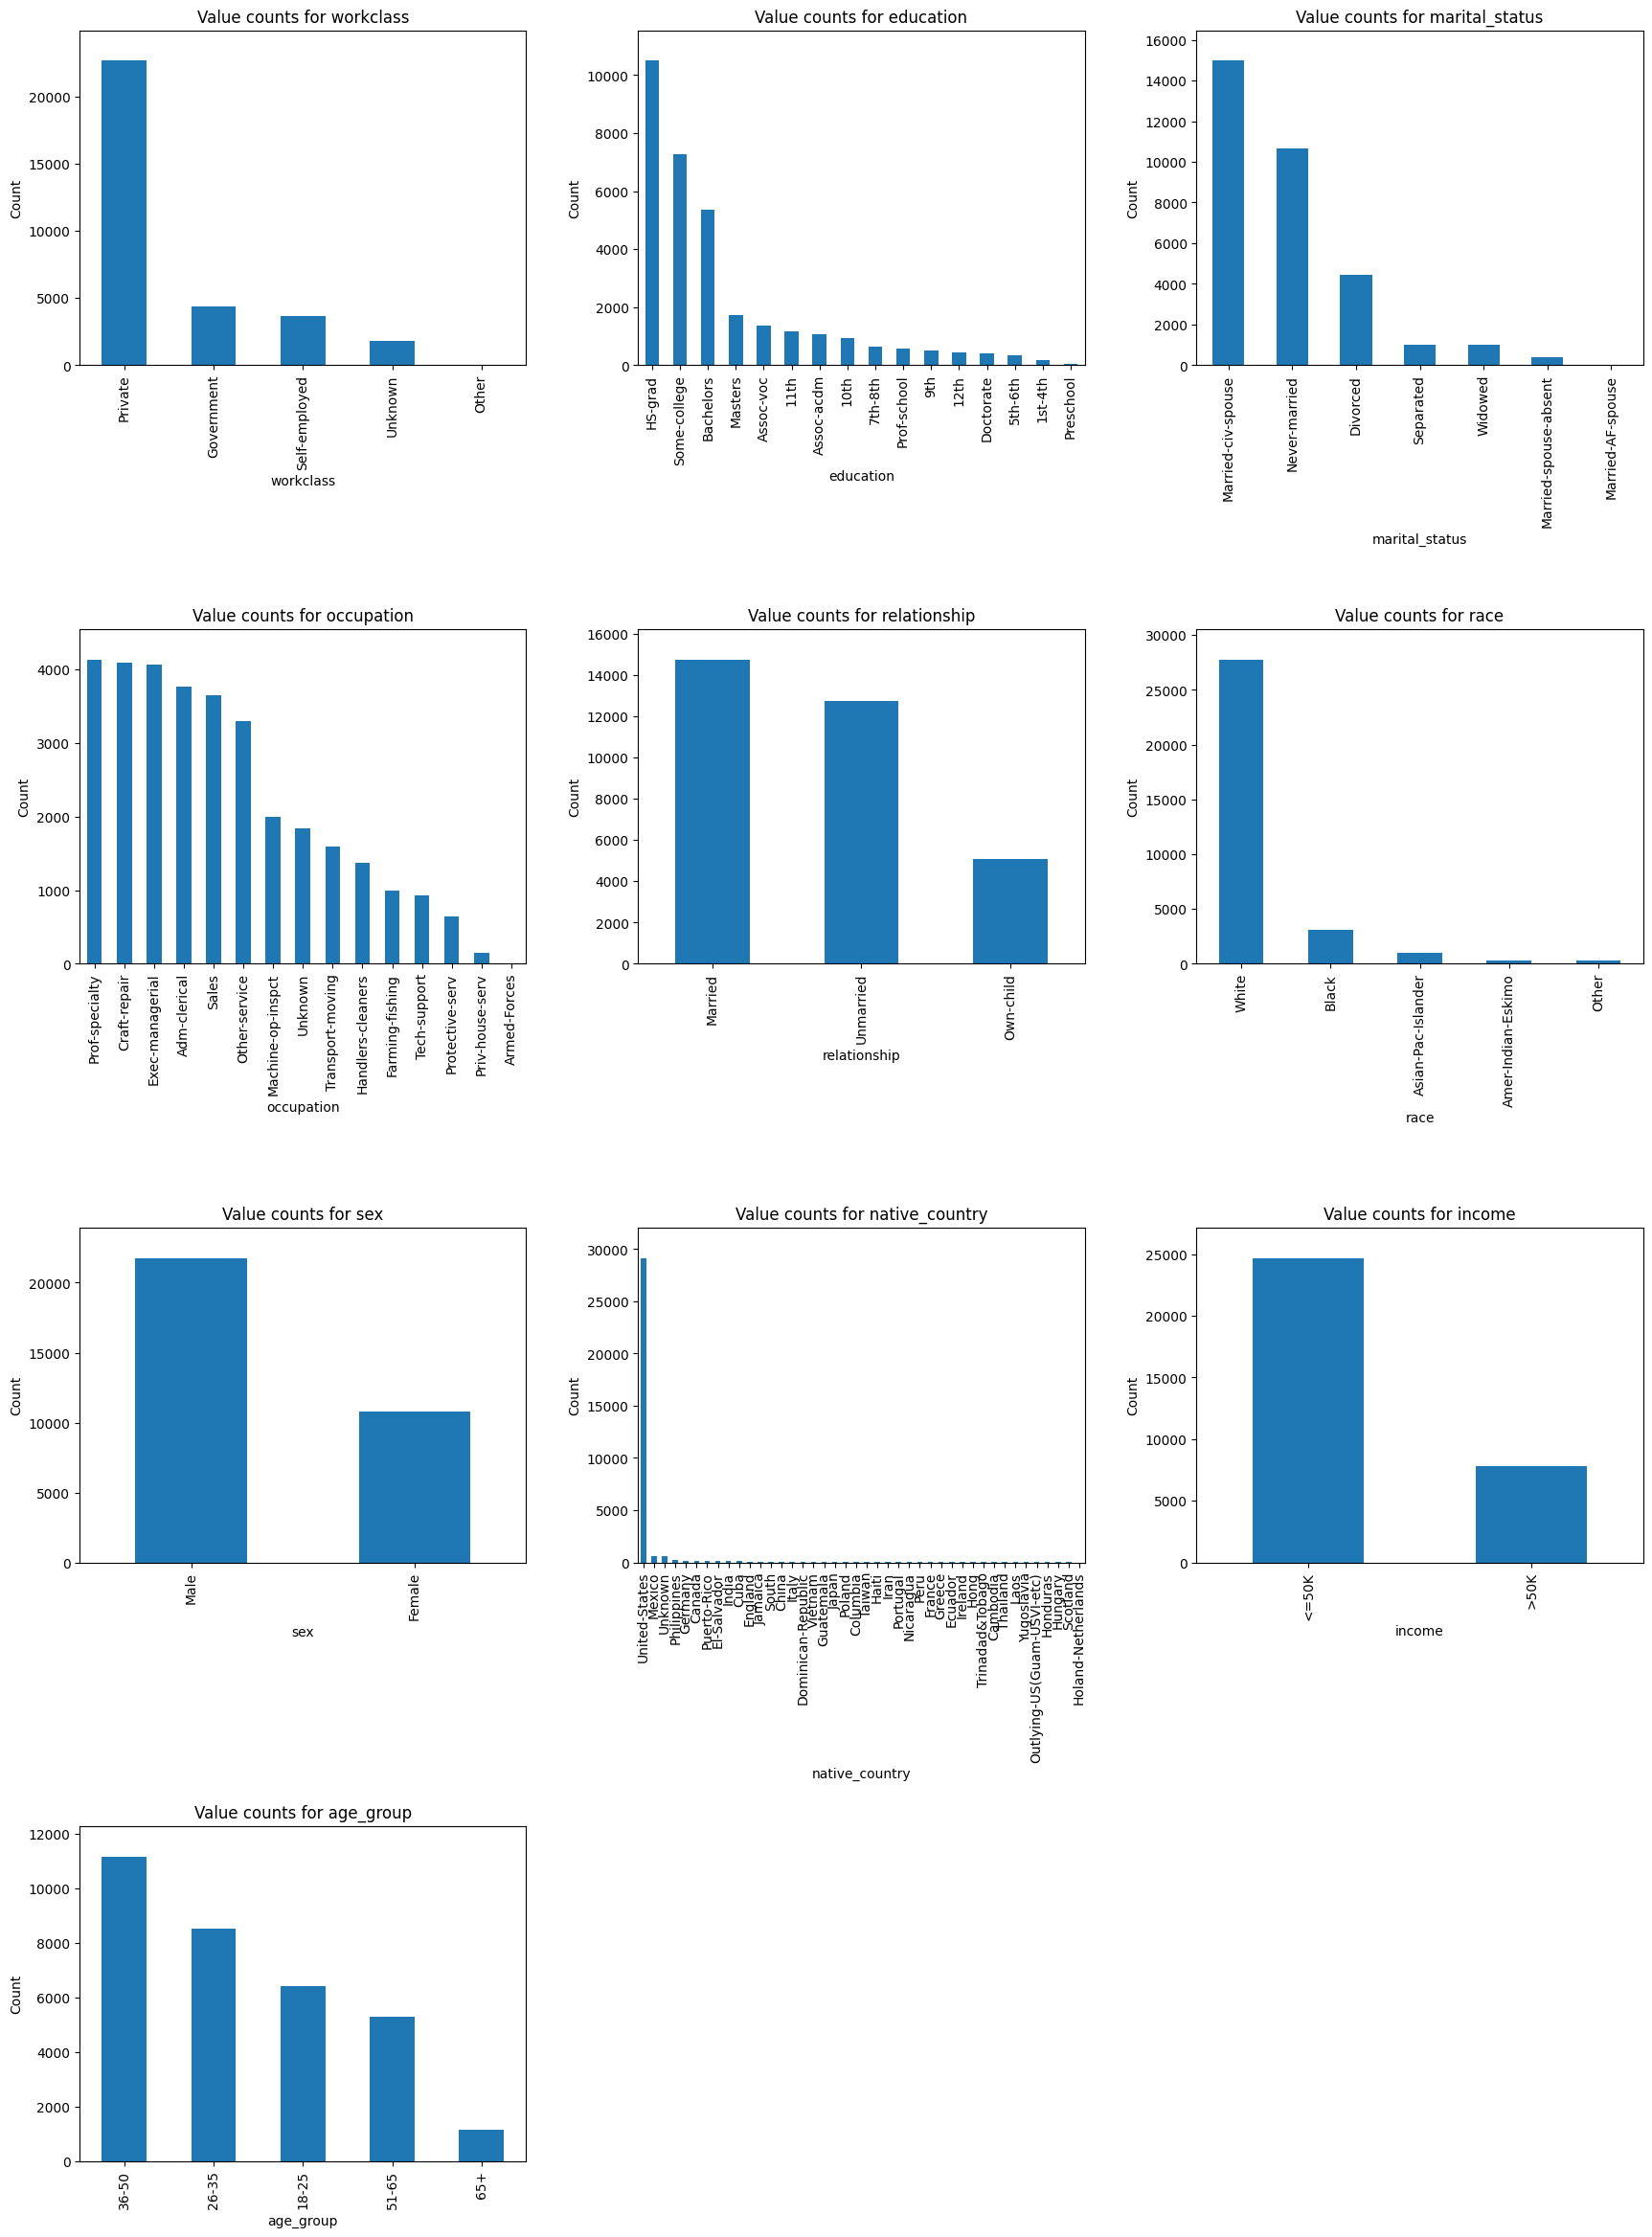

In [6]:
categorical_columns = df.select_dtypes(exclude='number').columns
utils.plot_categorical_value_counts(df, categorical_columns).show()

### 2.1.6 Creating Calculated Columns
- A net capital column was created as a new calculated field for the analysis, considering both capital gains and losses. The formula for this column is `net_capital = capital_gain - capital_loss`.
- `has_capital_gain` is a binary column that indicates whether a person's net capital is greater than 0. A value of 1 represents a positive net capital, while 0 represents no gain.
- `work_intensity` is a normalized column that measures the relative number of hours worked per week compared to the maximum hours in the dataset. The formula is `work_intensity = hours_per_week / max(hours_per_week)`.
- `works_full_time` is a binary column that identifies whether a person works full-time. A value of 1 indicates that the individual works at least 35 hours per week, while 0 indicates part-time work.

In [7]:
df['net_capital'] = df['capital_gain'] - df['capital_loss']
df['has_capital_gain'] = (df['net_capital'] > 0).astype(int)
df['work_intensity'] = df['hours_per_week'] / df['hours_per_week'].max()
df['works_full_time'] = (df['hours_per_week'] >= 35).astype(int)

## 2.2 Exploratory Data Analysis
### 2.2.1 Stacked Bar Chart

This stacked bar chart represents proportion of the 2 income groups (<=50K and >50K) for each categorical column. This visualizations helps me to understand how does each feature contribute to an individual's income definition.

{'Bachelors': 13, 'HS-grad': 9, '11th': 7, 'Masters': 14, '9th': 5, 'Some-college': 10, 'Assoc-acdm': 12, 'Assoc-voc': 11, '7th-8th': 4, 'Doctorate': 16, 'Prof-school': 15, '5th-6th': 3, '10th': 6, '1st-4th': 2, 'Preschool': 1, '12th': 8}


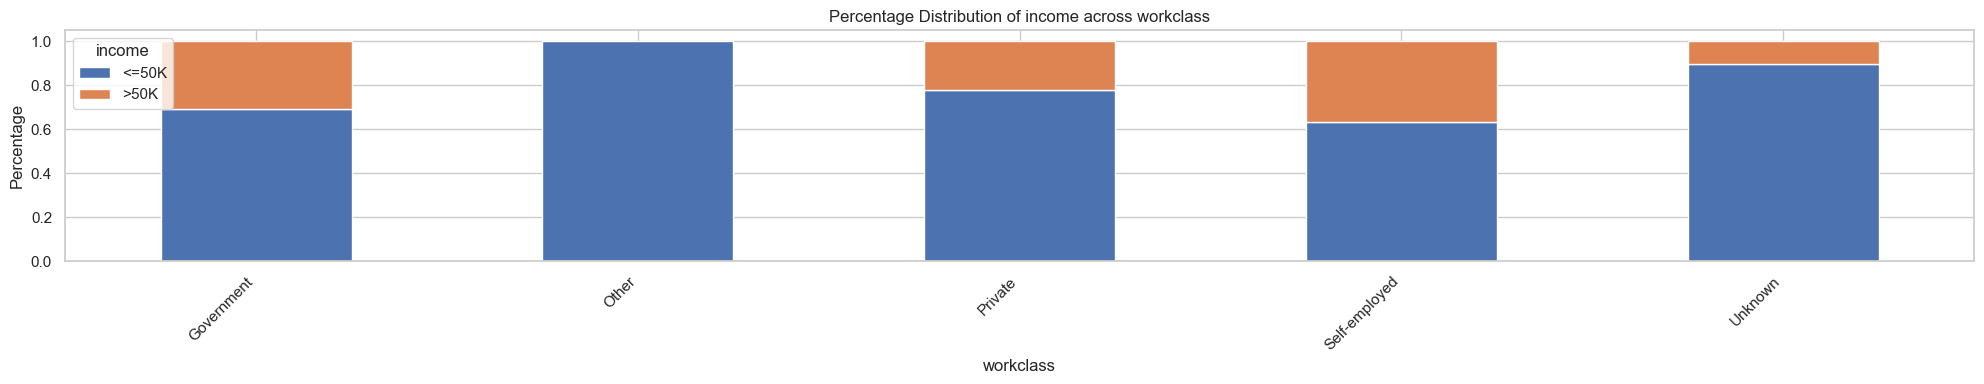

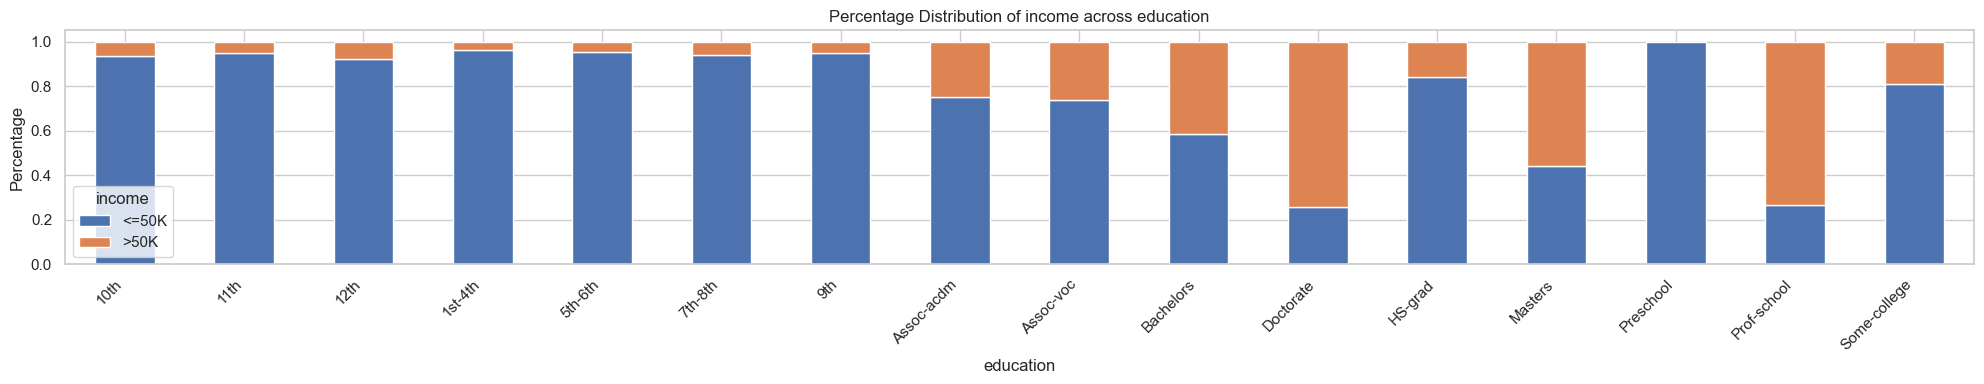

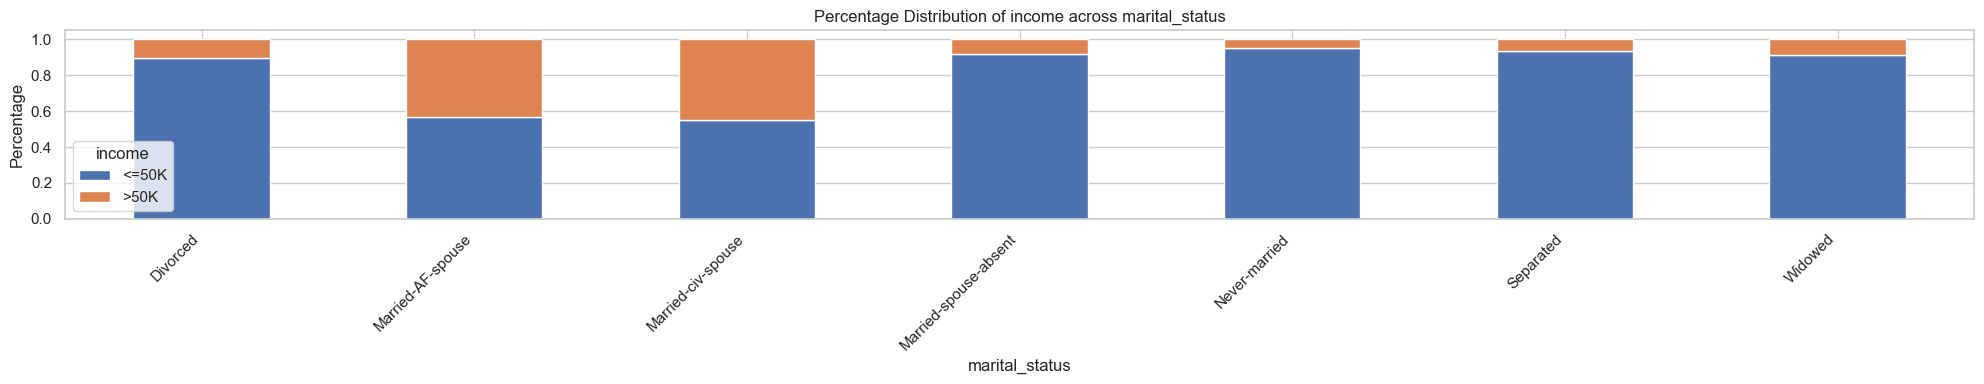

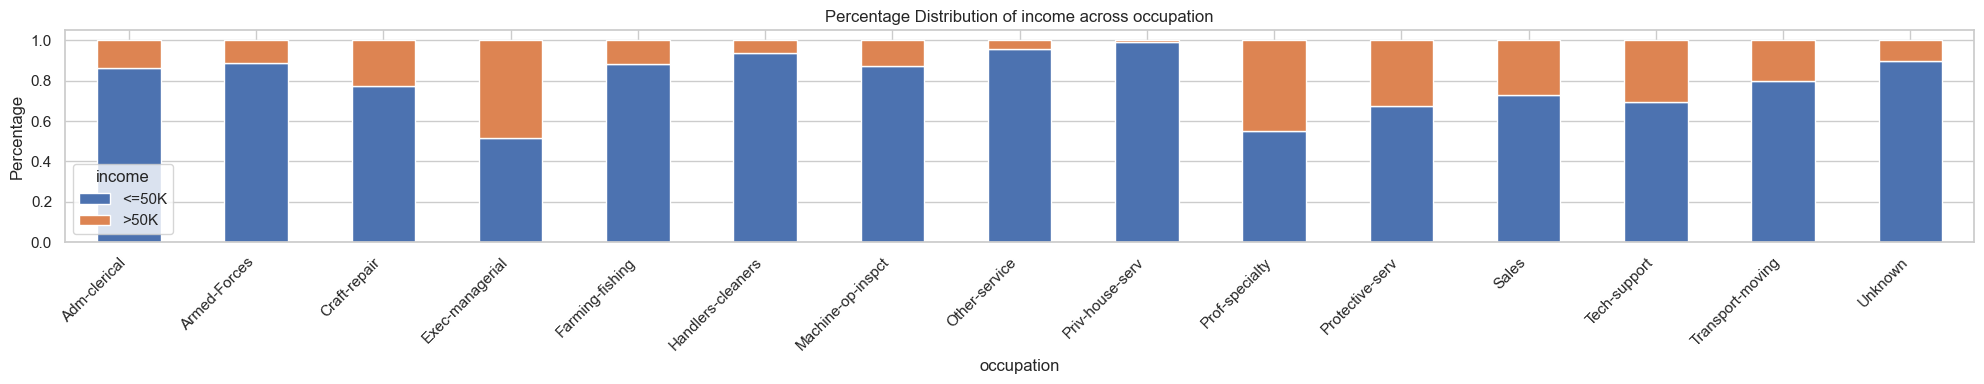

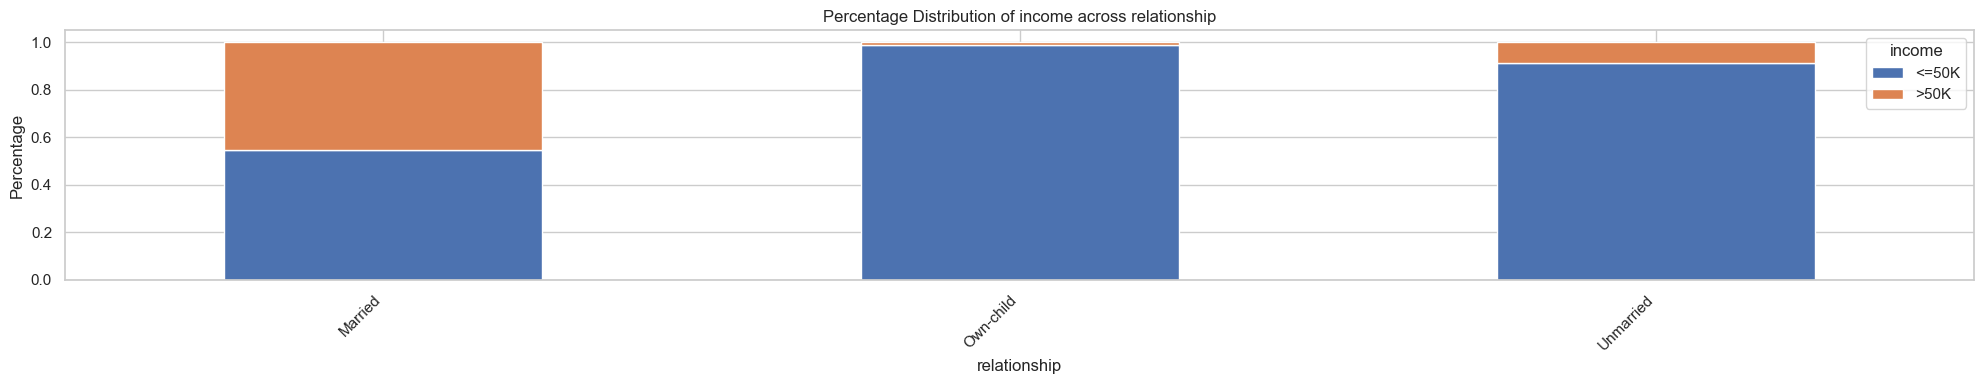

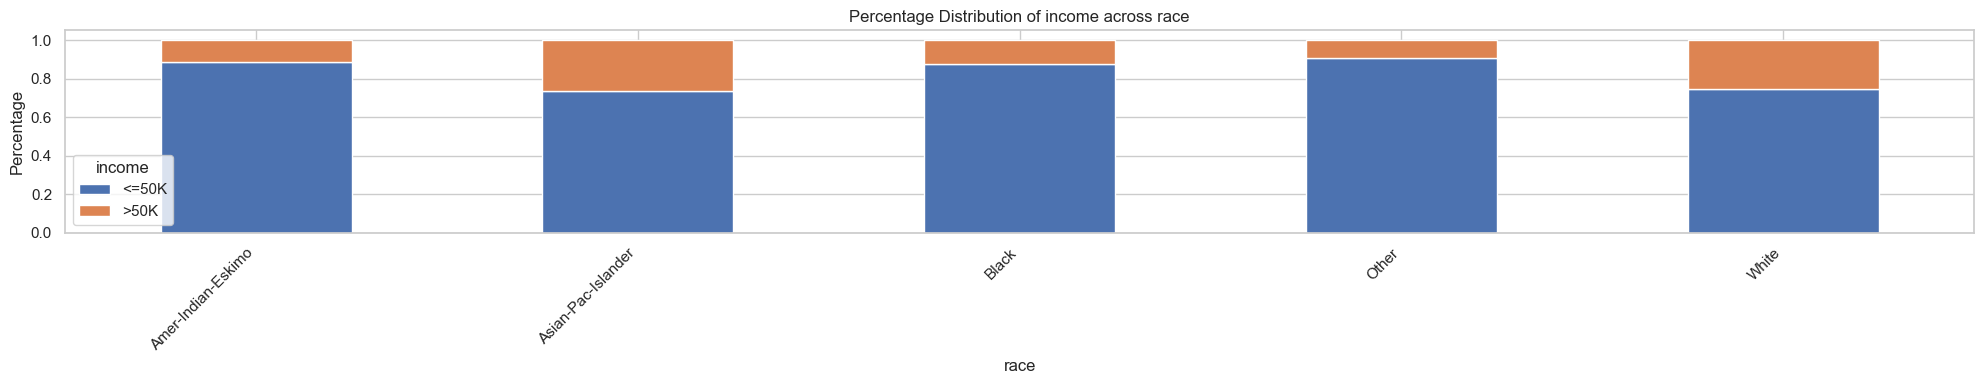

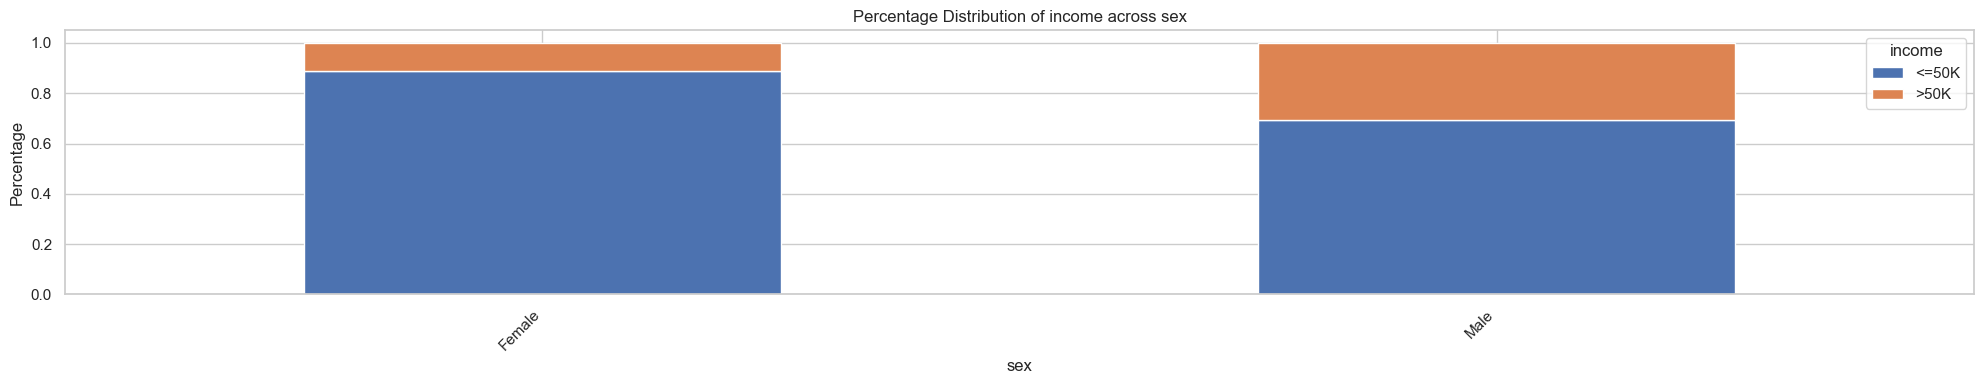

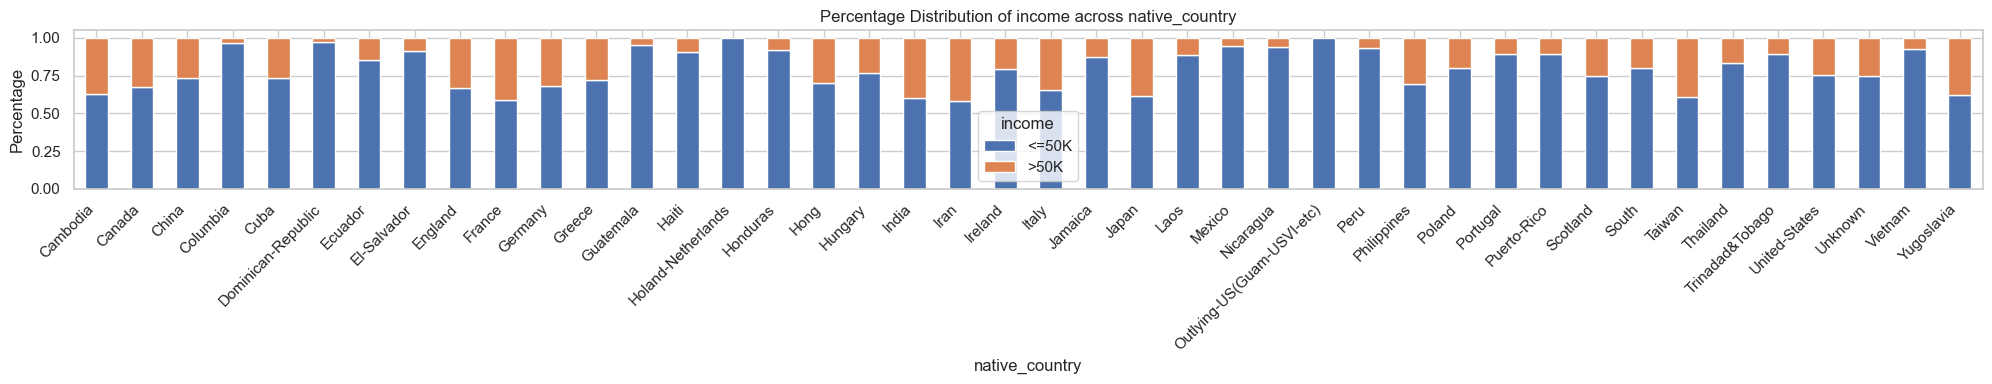

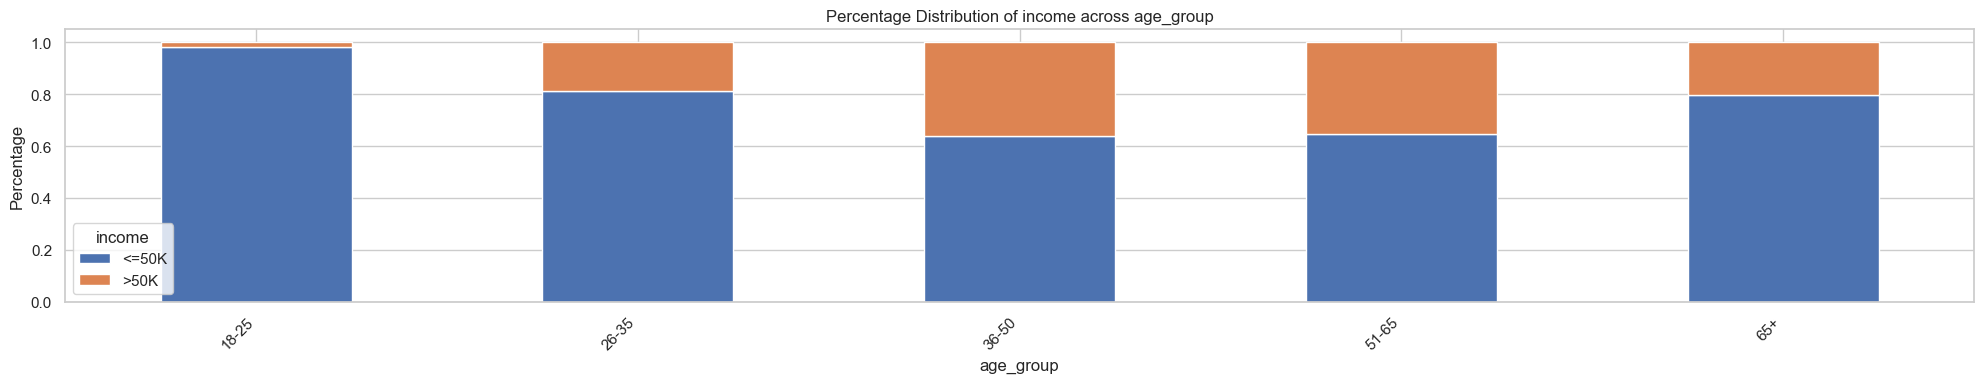

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

print(education_num_dict)
plots = categorical_columns.drop('income')
utils.plot_categorical_proportions(df, plots, 'income', palette="deep")


### 2.2.2 Scatter Plot Correlation Between Gains and Capital
This visualization came out of a question. Do high earners actually have a higher net capital? 

It is meant to discard a possible unexpected behavior in which some high earners wouldn't have a high net capital due to external factors.

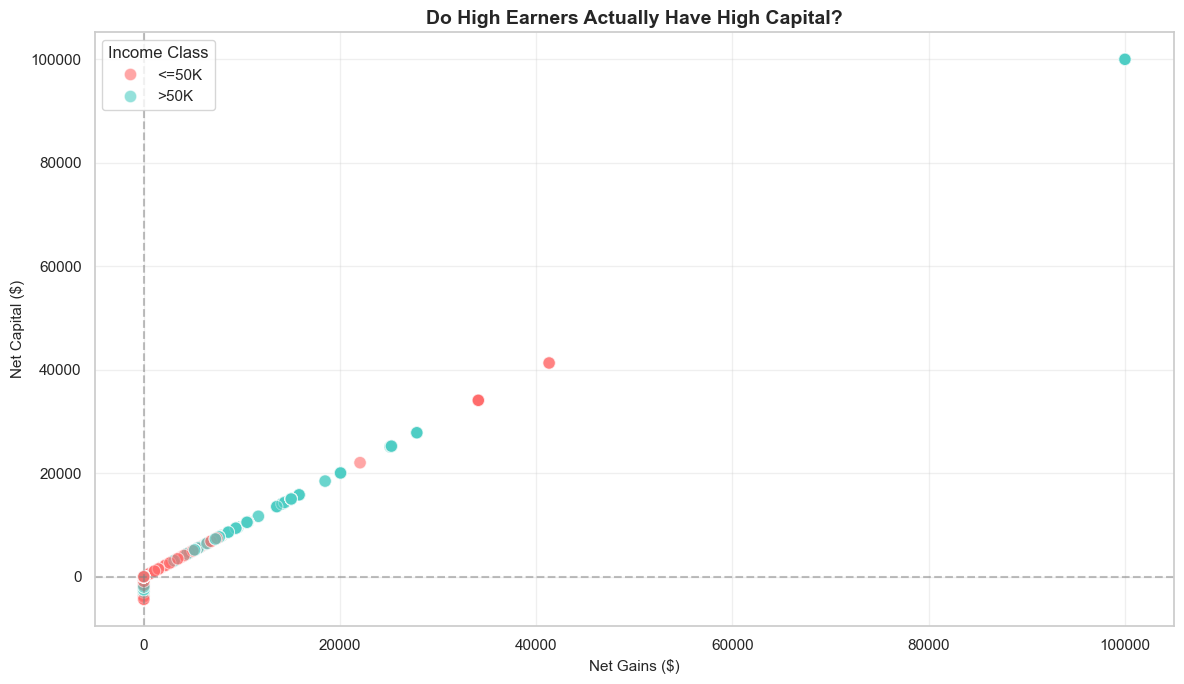

In [30]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.scatterplot(data=df, x='capital_gain', y='net_capital', hue='income', 
                palette={'<=50K': '#FF6B6B', '>50K': '#4ECDC4'}, alpha=0.6, s=80, ax=ax)

plt.title('Do High Earners Actually Have High Capital?', fontsize=14, fontweight='bold')
plt.xlabel('Net Gains ($)', fontsize=11)
plt.ylabel('Net Capital ($)', fontsize=11)

# Let seaborn's legend handle the colors automatically
ax.legend(title='Income Class', loc='upper left')

plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.grid(alpha=0.3)
plt.tight_layout()


### 2.2.3 Box Plots to Understand Work Intensity By Income Type
This visualization shows the distribution of work intensity for each income type. It represents work intensity as a percentage of the total number of hours worked per week for both high earners and low earners.


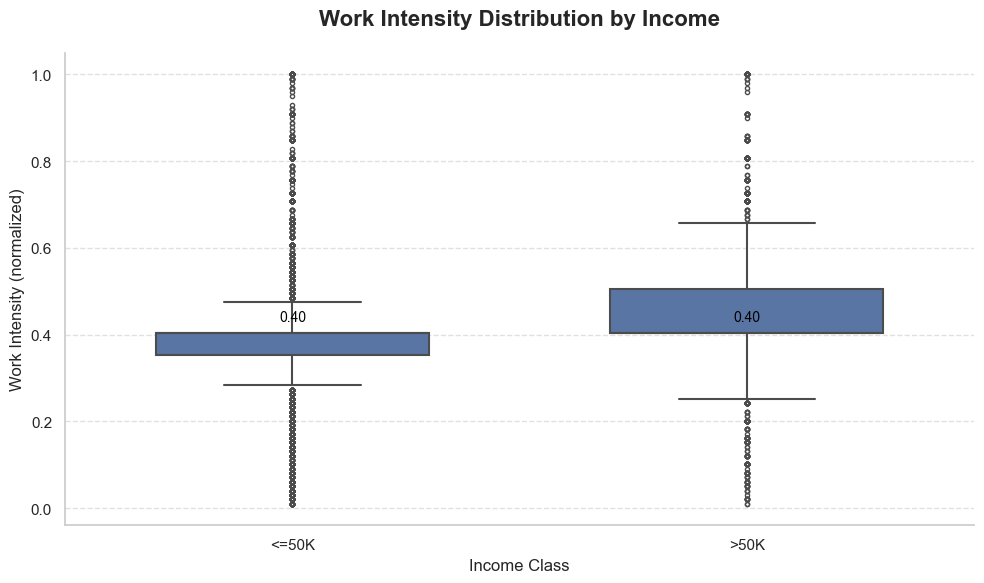

,count,mean,std,min,25%,50%,75%,max
income,,,,,,,,
<=50K,24697.0,0.392352,0.124430,0.010101,0.353535,0.40404,0.404040,1.0
>50K,7839.0,0.459327,0.111254,0.010101,0.404040,0.40404,0.505051,1.0


In [10]:
plt.figure(figsize=(10, 6))

sns.boxplot(
    x='income',
    y='work_intensity',
    data=df,
    width=0.6,
    fliersize=3,   # smaller outlier markers
    linewidth=1.5
)


# Titles and labels
plt.title('Work Intensity Distribution by Income', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Income Class', fontsize=12)
plt.ylabel('Work Intensity (normalized)', fontsize=12)

# Grid and style tweaks
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine()

# Annotate medians
medians = df.groupby('income')['work_intensity'].median()
for i, median in enumerate(medians):
    plt.text(i, median + 0.02, f'{median:.2f}', 
             ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()
df.groupby('income')['work_intensity'].describe()


### 2.2.4 Stacked Bar Chart: Gender proportions in Education and Work Features
As seen in the previous data exploration notebook, the `sex` column is very imbalanced, with a majority of men in the dataset. This visuazation drills down into the education and work features to see if there are any patterns that can further explain it.

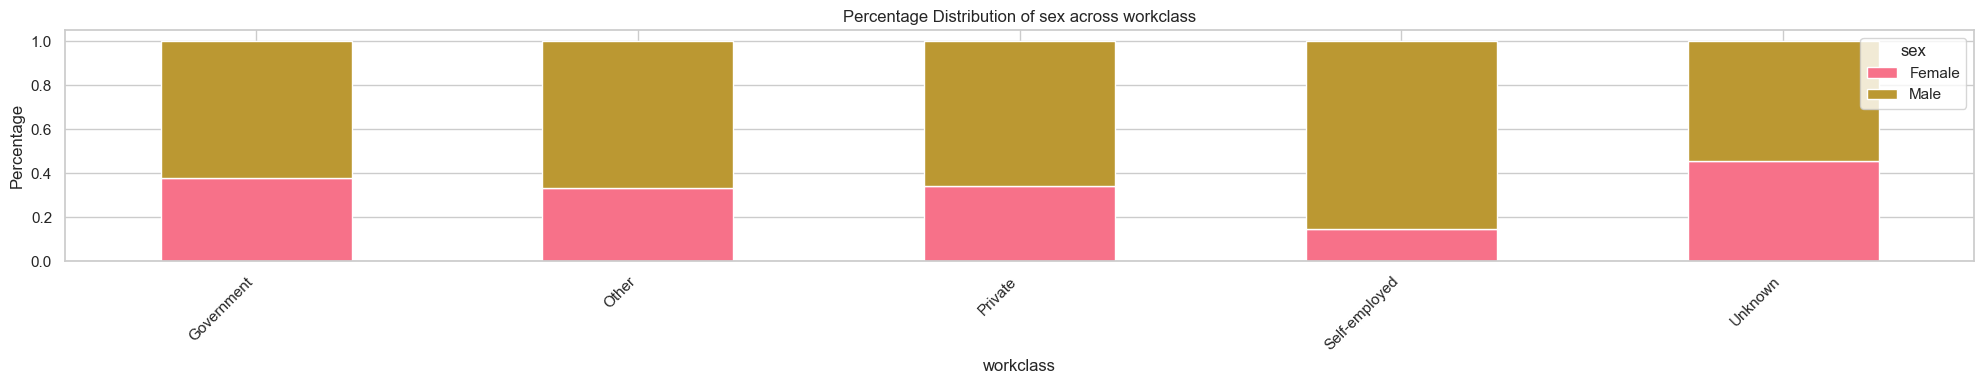

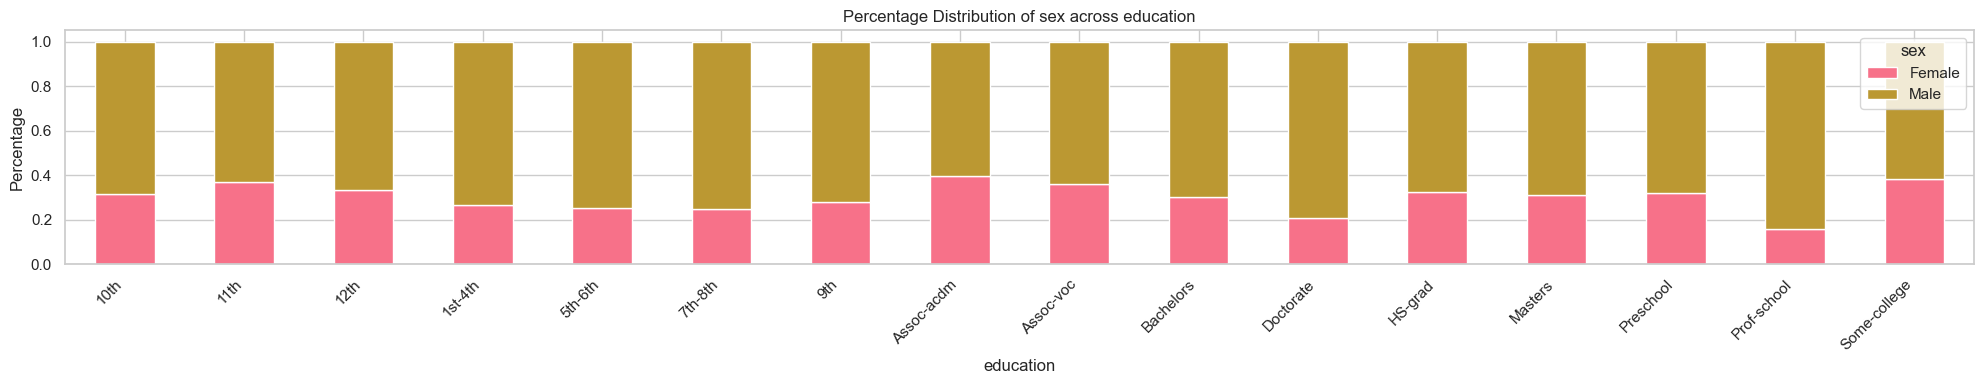

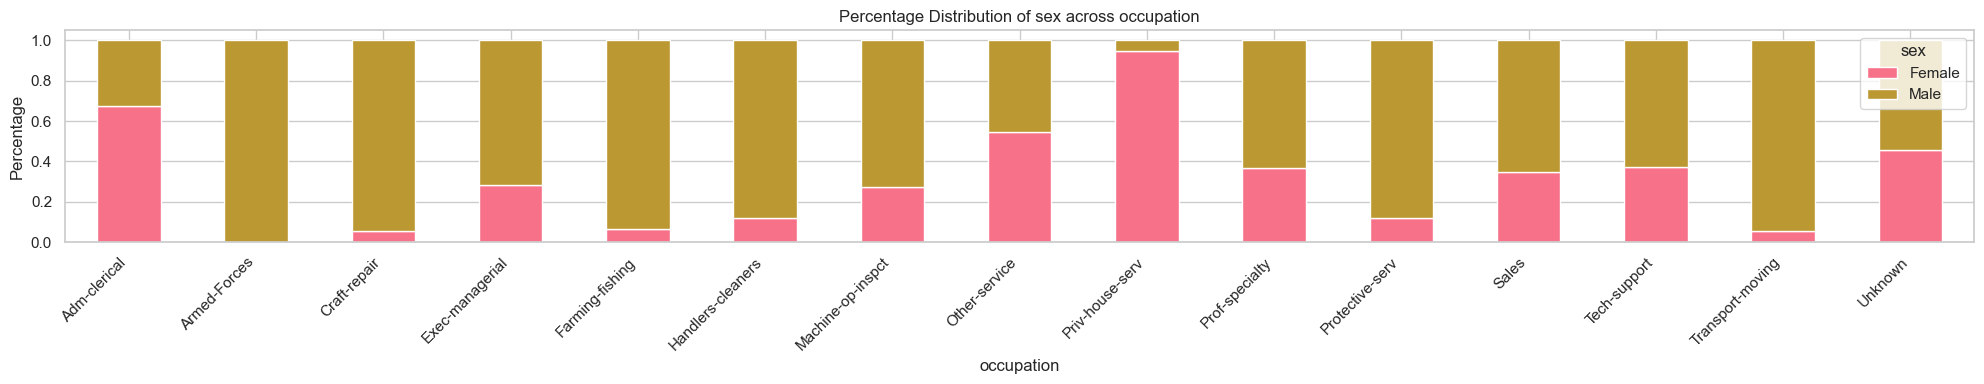

In [11]:
gender_plots = ['workclass', 'education', 'occupation']

utils.plot_categorical_proportions(df, categorical_cols=gender_plots, target_col='sex')

### 2.2.5 Scatter Plot: Education Level vs Work Hours and Net Capital.
This scatter plot shows the relationship between the education level of the participatns, and their work hours and net capital. This visualization works as a continuation of what I was trying to represent in the proportions plot by education as I noticed this was one of the colums that influenced the income type the most. It is easy to identify the amount of participants per education level (size of the dots), the amount of work hours they work in average as well as how is this information related to the net capital they have.


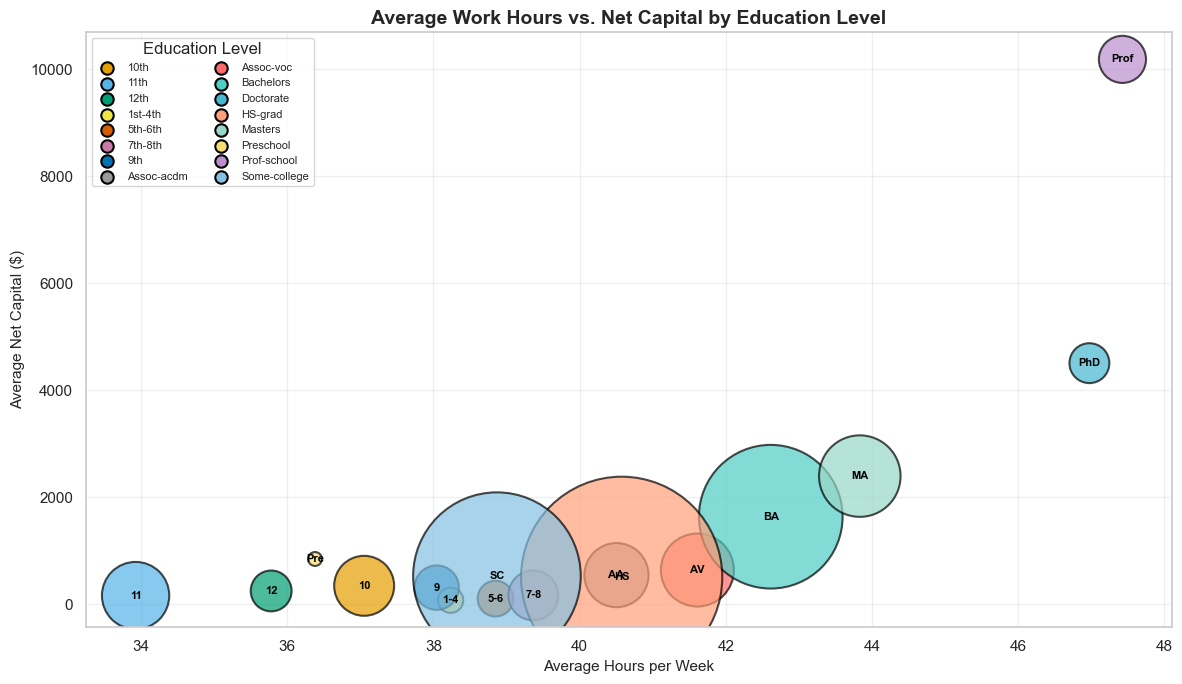

In [33]:
grouped = df.groupby('education', as_index=False).agg({
    'hours_per_week': 'mean',
    'net_capital': 'mean',
    'sex': 'count'
}).rename(columns={'sex': 'count'})

# Create abbreviations for education levels
abbrev_map = {
    '10th': '10', '11th': '11', '12th': '12',
    '1st-4th': '1-4', '5th-6th': '5-6', '7th-8th': '7-8', '9th': '9',
    'Assoc-acdm': 'AA', 'Assoc-voc': 'AV', 'Bachelors': 'BA',
    'Doctorate': 'PhD', 'HS-grad': 'HS', 'Masters': 'MA',
    'Preschool': 'Pre', 'Prof-school': 'Prof', 'Some-college': 'SC'
}
grouped['abbrev'] = grouped['education'].map(abbrev_map)

colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#D55E00', '#CC79A7', 
          '#0072B2', '#999999', '#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', 
          '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E2']


fig, ax = plt.subplots(figsize=(12, 7))


scatter = ax.scatter(grouped['hours_per_week'], 
                     grouped['net_capital'], 
                     s=grouped['count'] * 2, 
                     alpha=0.7, 
                     c=[colors[i] for i in range(len(grouped))],  # assign unique color per education
                     edgecolors='black',
                     linewidth=1.5)

# Add abbreviation labels inside circles
for idx, row in grouped.iterrows():
    ax.annotate(row['abbrev'], 
                xy=(row['hours_per_week'], row['net_capital']),
                ha='center', va='center',
                fontsize=8, fontweight='bold', color='black')

plt.title('Average Work Hours vs. Net Capital by Education Level', 
          fontsize=14, fontweight='bold')
plt.xlabel('Average Hours per Week', fontsize=11)
plt.ylabel('Average Net Capital ($)', fontsize=11)


# Create custom legend for education levels
education_levels = grouped['education'].values
for i, edu in enumerate(education_levels):
    ax.scatter([], [], s=80, c=colors[i], 
               edgecolors='black', linewidth=1.5, label=edu)


ax.legend(scatterpoints=1, title='Education Level', loc='upper left', 
          frameon=True, fontsize=8, ncol=2)  # ncol=2 for narrower legend


# Add gridlines for easier reading
ax.grid(alpha=0.3)
plt.tight_layout()


## 2.3 Analysis Question
### 2.3.1 Define the Analysis Question
The EDA processed uncovered interesting patterns in the dataset, as well as unexpected insights related to the different categories and numerical information available. My focus in this analysis is to understand common caracteristics of high earners and get a great picture of the real income distribution.

#### The Question

**What combination of education, occupation, gender, and work intensity defines high earners (>50K) in this dataset?**

#### At A Glance

About **30% of people earn above 50K annually**, but they're not spread evenly. They cluster in specific education levels, occupations, and demographics. Let's break down what makes them different.

### 2.3.2 Gathering Insights from EDA
#### Education Matters

The data makes one thing clear: **more education = higher income**, and the jumps are significant.

- People with **advanced degrees** (Doctorate, Masters, Professional-school) earn >50K at rates of 70–80%.
- Those with a **Bachelor's degree** sit in the middle: about 33–40% earn >50K.
- **High school graduates** rarely break 50K: only ~10% do.

A Bachelor's degree roughly triples your chances of high income compared to high school alone.

#### Occupation Matters as Much as Education

Where you work is just as important as what you know.

- **Executive, professional, and specialized roles** consistently show around 50% of workers earning >50K.
- **Sales and technical roles** are middle-ground: 15–25% earn more than 50K.
- **Service, cleaning, and farming roles** almost never break into the >50K group.

Two people with the same education level can have vastly different incomes depending on their occupation. This suggests that *access* to good jobs, not just qualifications, is a real barrier.

#### The Gender Problem

The data reveals uncomfortable truths about gender and income:

- **The dataset is 67% male**, but even thought proportion analysis was created to compare earnings despite this imbalance, men dominate high-income jobs and advanced education.
- **Occupational segregation:** Women are overrepresented in low-paying roles (service, housework) while men dominate high-paying ones (executive, professional).

#### Working Hard Isn't Enough

**People in both income groups work similar hours.**

- Both high earners (>50K) and low earners (<=50K) average 35–48 hours per week.
- Many people at 50+ hours still earn <=50K.
- Conversely, some high earners comfortably earn >50K on 40 hours.


#### Money From Investments? Not Really

One surprise: **most high earners don't make significant money from investments or capital gains.**

The scatter plot reveals a striking pattern: a massive cluster of both low and high earners sits near zero net capital. Even among people earning >50K, the vast majority have almost no investment income. They're earning through **wages and salaries**, not stock portfolios or rental properties.

Only a tiny fraction of high earners have meaningful capital—people with $20,000 to $100,000+ in net capital appear as isolated outliers. The rest are stacked together at the origin, proving that capital accumulation isn't the pathway to high income for most people.

- I can spot blue dots (high earners) mixed right in with red dots (low earners) along the left edge of the plot. These high earners have zero capital but still cross the 50K threshold through their jobs. Meanwhile, a handful of red dots with some capital never reach 50K, showing that capital without a good income source doesn't guarantee success.

**Conclusion:** For the average person, the path to >50K is your job, not your investment portfolio. Capital income is concentrated among the already-wealthy and plays almost no role in determining who earns above the threshold.

### 2.3.3 Answering the Question

**High earners share a specific profile:**
- Highly educated (Bachelor's degree minimum, often more)
- In good-paying occupations (executive, professional, technical)
- Disproportionately male (even when equally qualified as women)
- Working full-time (but not dramatically longer than low earners)

**Gender gaps persist even when education and hours worked are identical.** This isn't just about individual choices, it reflects real structural barriers that affect who gets access to high-income jobs and careers.

For anyone trying to earn >50K, the data suggests the same pathway: get educated and access a good occupation. But it also suggests that gender still plays an unfair role in determining who gets those opportunities.

